# Data Smart Sans Excel

[Table of Contents](Data%20Smart%20Sans%20Excel.ipynb)

If you have not downloaded the Data Smart files then run the first code block of the main notebook and it will download the files from the web. 

## Chapter 5 - Network Graphs and Community Detection

### Using Friends Data to Create Network Graph

In [19]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import community # used for Louvain method
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
FriendsGraph = os.path.join(os.getcwd(), "data_smart_files", "ch05", "FriendsGraph.xlsx")
adjacency_matrix = pd.read_excel(FriendsGraph, 'FriendsGraph', parse_cols = "A:G", index_col=0)
adjacency_matrix

In [15]:
def generate_edges(m):
    if not isinstance(m,pd.DataFrame):
        print ('only currently support DataFrame')
        return []
    edge_list = []
    for row in m.items():
        left = row[0]; adjacents = row[1]
        for w in adjacents[adjacents==1].items():
            right = w[0]
            if (left,right) not in edge_list and (right,left) not in edge_list:
                edge_list.append((left,right))
    return edge_list

In [ ]:
G = nx.Graph()
G.add_nodes_from(adjacency_matrix.index)
G.add_edges_from(generate_edges(adjacency_matrix))
print('The graph consists of {} nodes and {} edges.'.format(G.number_of_nodes(),G.number_of_edges()))

In [ ]:
nx.draw(G,with_labels=True,node_color='c',font_weight='bold')
print('The graphs average degree is {0:.2f}'.format(np.average(np.array(list(G.degree().values())))))

### Wine Data Analysis

In [9]:
WineNetwork = os.path.join(os.getcwd(), "data_smart_files", "ch05", "WineNetwork.xlsx")
wine_matrix = pd.read_excel(WineNetwork, 'Matrix', parse_cols = "A:DC", index_col=0)

#### Create Cosine Similarity Matrix
A Cosine Similarity Matrix is the count of matched purchases in the two vectors divided by the product of the square root of the number of purchases in the first vector times the square root of the number of purchases in the second vector.

In [10]:
wine_matrix_simple = wine_matrix.copy()
for c in ('Campaign','Varietal','Minimum Qty (kg)','Discount (%)','Origin','Past Peak'):
    del wine_matrix_simple[c]
customer_count = len(wine_matrix_simple.columns)
cos_sim_matrix = np.zeros((customer_count,customer_count))

In [11]:
for i,customer1 in enumerate(wine_matrix_simple.columns):
    for j,customer2 in enumerate(wine_matrix_simple.columns):
        cust1 = wine_matrix_simple[customer1]
        cust2 = wine_matrix_simple[customer2]
        if customer1 == customer2:
            cos_sim_matrix[i,j] = 0
            continue
        cos_sim_matrix[i,j] = (cust1 * cust2).sum() / (np.sqrt(cust1.sum()) * np.sqrt(cust2.sum()))
cos_sim_matrix_df = pd.DataFrame(cos_sim_matrix,
                                 index=wine_matrix_simple.columns,
                                 columns=wine_matrix_simple.columns)
cos_sim_matrix_df.head(5)

,Adams,Allen,Anderson,Bailey,Baker,Barnes,Bell,Bennett,Brooks,Brown,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
Adams,0.000000,0.0,0.0,0.408248,0.000000,0.0,0.000000,0.408248,0.0,0.666667,...,0.000000,0.816497,0.0,0.408248,0.288675,0.333333,0.408248,0.0,0.000000,0.000000
Allen,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.353553,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.353553,0.288675
Anderson,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.707107,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Bailey,0.408248,0.0,0.0,0.000000,0.353553,0.0,0.000000,0.000000,0.0,0.816497,...,0.000000,0.000000,0.0,0.500000,0.353553,0.000000,0.500000,0.0,0.000000,0.000000
Baker,0.000000,0.0,0.0,0.353553,0.000000,0.5,0.000000,0.000000,0.0,0.288675,...,0.250000,0.000000,0.0,0.353553,0.000000,0.288675,0.000000,0.5,0.000000,0.204124


#### Create r-Neighborhood Graph
An r-neighborhood graph is a way to prune the graph by only keeping the edges that are of a certain strength.

In [12]:
unpruned_edges = cos_sim_matrix_df.where(cos_sim_matrix_df>0).count().sum()
print('The unpruned graph contains {} edges. An 80% reduction would be {} edges.'.format(unpruned_edges,
                                                                                         unpruned_edges*0.2))

The unpruned graph contains 2950 edges. An 80% reduction would be 590.0 edges.


In [13]:
csm_flat = cos_sim_matrix.flatten()
csm_flat.sort()
reduced_edge_count = int(unpruned_edges*.2)
r = csm_flat[-reduced_edge_count] - 0.001
cos_sim_matrix_r = np.where(cos_sim_matrix >= r,1,0)
cos_sim_matrix_df = pd.DataFrame(cos_sim_matrix_r,
                                 index=wine_matrix_simple.columns,
                                 columns=wine_matrix_simple.columns)
cos_sim_matrix_df.head(5)

,Adams,Allen,Anderson,Bailey,Baker,Barnes,Bell,Bennett,Brooks,Brown,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
Adams,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
Allen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Anderson,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
Baker,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
G = nx.Graph()
G.add_nodes_from(cos_sim_matrix_df.index)
G.add_edges_from(generate_edges(cos_sim_matrix_df))
print('The graph consists of {} nodes and {} edges.'.format(G.number_of_nodes(),G.number_of_edges()))

The graph consists of 100 nodes and 429 edges.


In [17]:
plt.figure(figsize=(10,8))
node_color=[float(G.degree(n)) for n in G]
nx.draw(G,with_labels=True,node_color=node_color,font_weight='bold',
        font_size=10,font_color='k',alpha=0.4)

### Graph Modularity Maximization 
Optimization algorithm to determine optimal groupings to maximize the modularity score

In [20]:
total_stubs = cos_sim_matrix_df.sum().sum()
gmm_matrix = np.zeros((customer_count,customer_count))
for i,customer1 in enumerate(cos_sim_matrix_df.columns):
    for j,customer2 in enumerate(cos_sim_matrix_df.columns):
        gmm_matrix[i,j] = (cos_sim_matrix_df.loc[customer1,customer2] - (cos_sim_matrix_df[customer1].sum() * 
                                                      cos_sim_matrix_df[customer2].sum()) / total_stubs)
modularity_df = pd.DataFrame(gmm_matrix,index=cos_sim_matrix_df.columns,
                             columns=cos_sim_matrix_df.columns)
modularity_df.head(5)

,Adams,Allen,Anderson,Bailey,Baker,Barnes,Bell,Bennett,Brooks,Brown,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
Adams,-0.228438,-0.097902,-0.212121,-0.277389,-0.114219,-0.097902,-0.212121,-0.244755,-0.130536,0.755245,...,-0.130536,0.771562,-0.081585,-0.261072,-0.048951,-0.048951,-0.293706,-0.081585,-0.065268,-0.065268
Allen,-0.097902,-0.041958,-0.090909,-0.118881,-0.048951,-0.041958,-0.090909,-0.104895,-0.055944,-0.104895,...,-0.055944,-0.097902,-0.034965,-0.111888,-0.020979,-0.020979,-0.125874,-0.034965,-0.027972,-0.027972
Anderson,-0.212121,-0.090909,-0.196970,-0.257576,-0.106061,-0.090909,0.803030,-0.227273,-0.121212,-0.227273,...,-0.121212,-0.212121,-0.075758,-0.242424,-0.045455,-0.045455,-0.272727,-0.075758,-0.060606,-0.060606
Bailey,-0.277389,-0.118881,-0.257576,-0.336830,-0.138695,-0.118881,-0.257576,-0.297203,-0.158508,0.702797,...,-0.158508,-0.277389,-0.099068,0.682984,-0.059441,-0.059441,0.643357,-0.099068,-0.079254,-0.079254
Baker,-0.114219,-0.048951,-0.106061,-0.138695,-0.057110,0.951049,-0.106061,-0.122378,-0.065268,-0.122378,...,-0.065268,-0.114219,-0.040793,-0.130536,-0.024476,-0.024476,-0.146853,0.959207,-0.032634,-0.032634


### Clustering (Louvain method)

In [76]:
# This uses the community python-louvain package which contains the Louvain algorithm for community detection
partition = community.best_partition(G)

partition_df = pd.DataFrame.from_dict(partition,orient='index')
partition_df.columns = ['Group']
partition_df['Group'] += 1
print('{} groups were created, ranging in size from {} to {}.'.format(
        len(partition_df['Group'].unique()),
        partition_df['Group'].value_counts().values.min(),
        partition_df['Group'].value_counts().values.max()))

6 groups were created, ranging in size from 1 to 28.


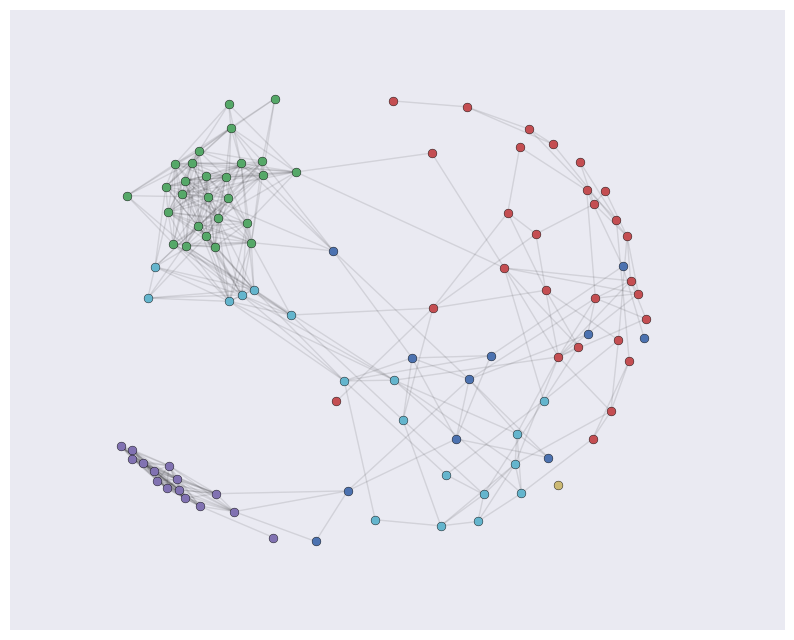

In [353]:
f, ax = plt.subplots()
f.set_size_inches(10,8)
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
size = len(partition_df['Group'].unique())
pos = nx.spring_layout(G)
colors =  ["#4C72B0", "#55A868", "#C44E52",
           "#8172B2", "#CCB974", "#64B5CD"]
for group in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() 
                  if partition[nodes] == group]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 40,
                           node_color = colors[group-1])
nx.draw_networkx_edges(G,pos, alpha=0.1)

### Top Offers by Cluster (based on louvain method)
Below each of the major deals in each cluster are sorted by how many buyers (within the cluster) participated. 

In [326]:
offer_info_df = pd.read_excel(WineNetwork, 'Matrix', index_col=0,parse_cols='A:G')
grouped_offers = pd.DataFrame()
for grp in partition_df['Group'].unique():
    grouped_offers['Group '+str(grp)] = (wine_matrix_simple.fillna(0).sort_index() * 
    partition_df['Group'].where(partition_df['Group'] == grp).fillna(0).sort_index()).sum(axis=1)
offer_info_df['Total Takers (all group)'] = grouped_offers.sum(axis=1)

Below are the top deals for **Group 1**.
This has similarities to community 2 in the book in that both are driven by the  March Espumante orders although only a quarter of this offer was taken by members of this group. This group looks to be a bit of a bust.

In [160]:
this_group = 'Group 1'
offer_info_df['Offers Taken (this group)'] = grouped_offers[this_group]
offer_info_df.iloc[list(grouped_offers[this_group].sort_values(ascending=False).index-1)].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak,Total Takers (all group),Offers Taken (this group)
Offer #,,,,,,,,
8,March,Espumante,6,45,South Africa,False,40.0,10.0
22,August,Champagne,72,63,France,False,51.0,7.0
4,February,Champagne,72,48,France,True,25.0,7.0
6,March,Prosecco,144,86,Chile,False,27.0,7.0
27,October,Champagne,72,88,New Zealand,False,16.0,6.0


Below are the top deals for **Group 2**.
This has similarities to community 1 which includes orders 22,31,11,etc. But that grouping starts with 4 champagnes. We have two. But what is key about this group is that all of these wines are French. 

In [161]:
this_group = 'Group 2'
offer_info_df['Offers Taken (this group)'] = grouped_offers[this_group]
offer_info_df.iloc[list(grouped_offers[this_group].sort_values(ascending=False).index-1)].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak,Total Takers (all group),Offers Taken (this group)
Offer #,,,,,,,,
22,August,Champagne,72,63,France,False,51.0,12.0
11,May,Champagne,72,85,France,False,36.0,12.0
2,January,Pinot Noir,72,17,France,False,35.0,10.0
1,January,Malbec,72,56,France,False,30.0,10.0
28,November,Cabernet Sauvignon,12,56,France,True,12.0,8.0


Below are the top deals for **Group 3**.
This matches community 0 in the book which is made up of orders 30,7,29,18,8...

In [162]:
this_group = 'Group 3'
offer_info_df['Offers Taken (this group)'] = grouped_offers[this_group]
offer_info_df.iloc[list(grouped_offers[this_group].sort_values(ascending=False).index-1)].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak,Total Takers (all group),Offers Taken (this group)
Offer #,,,,,,,,
30,December,Malbec,6,54,France,False,66.0,48.0
29,November,Pinot Grigio,6,87,France,False,54.0,48.0
7,March,Prosecco,6,40,Australia,True,53.0,42.0
18,July,Espumante,6,50,Oregon,False,39.0,33.0
8,March,Espumante,6,45,South Africa,False,40.0,30.0


Below are the top deals for **Group 4**.

In [163]:
this_group = 'Group 4'
offer_info_df['Offers Taken (this group)'] = grouped_offers[this_group]
offer_info_df.iloc[list(grouped_offers[this_group].sort_values(ascending=False).index-1)].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak,Total Takers (all group),Offers Taken (this group)
Offer #,,,,,,,,
31,December,Champagne,72,89,France,False,56.0,44.0
9,April,Chardonnay,144,57,Chile,False,40.0,40.0
14,June,Merlot,72,64,Chile,False,36.0,36.0
22,August,Champagne,72,63,France,False,51.0,32.0
1,January,Malbec,72,56,France,False,30.0,20.0


Below are the top deals for **Group 5**.
This matches community 3 in the book. This is our Pinot group. 

In [164]:
this_group = 'Group 5'
offer_info_df['Offers Taken (this group)'] = grouped_offers[this_group]
offer_info_df.iloc[list(grouped_offers[this_group].sort_values(ascending=False).index-1)].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak,Total Takers (all group),Offers Taken (this group)
Offer #,,,,,,,,
24,September,Pinot Noir,6,34,Italy,False,60.0,60.0
26,October,Pinot Noir,144,83,Australia,False,69.0,55.0
17,July,Pinot Noir,12,47,Germany,False,35.0,35.0
2,January,Pinot Noir,72,17,France,False,35.0,25.0
12,May,Prosecco,72,83,Australia,False,14.0,5.0


Below are the top deals for **Group 6**.

In [165]:
this_group = 'Group 6'
offer_info_df['Offers Taken (this group)'] = grouped_offers[this_group]
offer_info_df.iloc[list(grouped_offers[this_group].sort_values(ascending=False).index-1)].head()

,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak,Total Takers (all group),Offers Taken (this group)
Offer #,,,,,,,,
16,June,Merlot,72,88,California,False,23.0,6.0
20,August,Cabernet Sauvignon,72,82,Italy,False,26.0,6.0
11,May,Champagne,72,85,France,False,36.0,6.0
31,December,Champagne,72,89,France,False,56.0,6.0
29,November,Pinot Grigio,6,87,France,False,54.0,6.0


Below are the modularity values for the communities computed here (which defines clusters) as well as the book's communities (which defines 4 clusters). 

In [176]:
print('The modularity value for the communities computed here:',community.modularity(partition,G))
books_cluster_df = pd.read_excel(WineNetwork, 'Communities', index_col=0,parse_cols='A:D')
books_partition = books_cluster_df['Community'].to_dict()
print('The modularity value for the communities from the book:',community.modularity(books_partition,G))

The modularity value for the communities computed here: 0.5518715938296358
The modularity value for the communities from the book: 0.5463592351704241


I used gephi to perform the clustering and then I exported the assignments.

In [320]:
gephi_output_df = pd.read_csv('gephi_out.csv',index_col=0)
gephi_partition = gephi_output_df['modularity_class'].to_dict()
print('The modularity value for the communities from gephi:',community.modularity(gephi_partition,G))

The modularity value for the communities from gephi: 0.5531783678636825


We can see that all 3 are quite close. We beat the book by about 1% and Gephi beat us by about 0.25%. 

Below I computer the modularity values directly (not relying on the community package). 

In [266]:
scores = cos_sim_matrix_df - (cos_sim_matrix_df.sum(axis=1).values.reshape((100,1)) * 
                     cos_sim_matrix_df.sum(axis=0).values.reshape((1,100)) / cos_sim_matrix_df.values.sum())

In [324]:
scoring_matrix = np.zeros((100,100))
for i in range(100):
    scoring_matrix[i,:] = np.where(partition_df['Group'].sort_index().values
                                   ==partition_df['Group'].sort_index().iloc[i],1,0)
modularity = np.multiply(scores.values,scoring_matrix).sum(axis=1).sum() / cos_sim_matrix_df.values.sum()

for i in range(100):
    scoring_matrix[i,:] = np.where(books_cluster_df['Community'].sort_index().values
                                   ==books_cluster_df['Community'].sort_index().iloc[i],1,0)
modularity_book = np.multiply(scores.values,scoring_matrix).sum(axis=1).sum() / cos_sim_matrix_df.values.sum()

for i in range(100):
    scoring_matrix[i,:] = np.where(gephi_output_df['modularity_class'].sort_index().values
                                   ==gephi_output_df['modularity_class'].sort_index().iloc[i],1,0)
modularity_gephi = np.multiply(scores.values,scoring_matrix).sum(axis=1).sum() / cos_sim_matrix_df.values.sum()
print('The modularity value for the communities computed here:',modularity)
print('The modularity value for the communities from the book:',modularity_book)
print('The modularity value for the communities from gephi:   ',modularity_gephi)

The modularity value for the communities computed here: 0.55187159383
The modularity value for the communities from the book: 0.54635923517
The modularity value for the communities from gephi:    0.553178367864


These all match those computed by community.modularity.

Below we graph the group (cluster) sizes for each of the 3 approaches. 

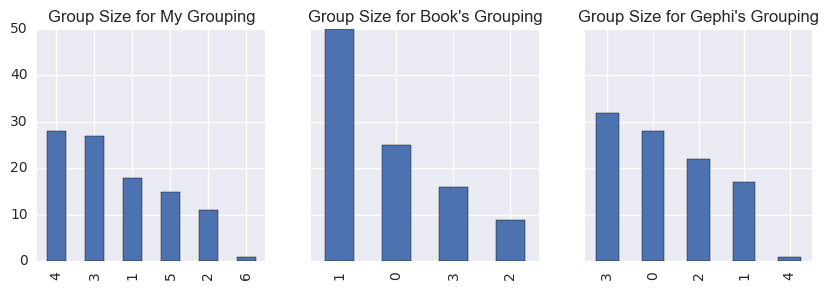

In [325]:
figure, (ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
figure.set_size_inches(10,3)
(partition_df['Group'].groupby(partition_df['Group'].values).count()
 .sort_values(ascending=False).plot(ax=ax1,kind='bar',title="Group Size for My Grouping"))
(books_cluster_df['Community'].groupby(books_cluster_df['Community'].values)
 .count().sort_values(ascending=False).plot(ax=ax2,kind='bar',title="Group Size for Book's Grouping"))
(gephi_output_df['modularity_class'].groupby(gephi_output_df['modularity_class'].values).count()
 .sort_values(ascending=False).plot(ax=ax3,kind='bar',title="Group Size for Gephi's Grouping"))

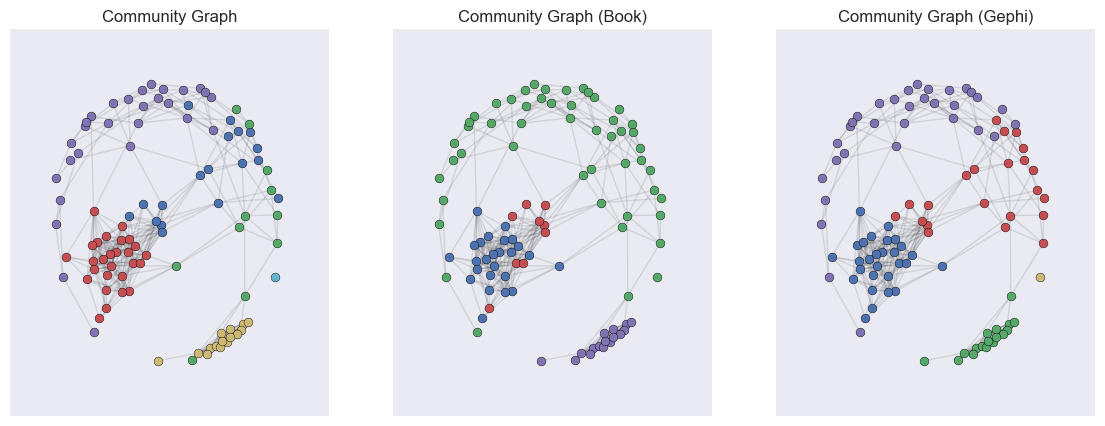

In [369]:
books_cluster_dict = books_cluster_df['Community'].to_dict()
gephi_output_dict = gephi_output_df['modularity_class'].to_dict()

figure, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,5))
pos = nx.spring_layout(G)
for name, d, ax in zip((None,'Book','Gephi'),(partition,books_cluster_dict,gephi_output_dict),(ax1,ax2,ax3)):
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if name is not None:
        title = 'Community Graph (%s)'%name
    else:
        title = 'Community Graph'
    ax.set_title(title)
    size = len(set(d.values()))
    colors =  ["#4C72B0", "#55A868", "#C44E52",
               "#8172B2", "#CCB974", "#64B5CD"]
    for i, group in enumerate(set(d.values())):
        list_nodes = [nodes for nodes in d.keys() 
                      if d[nodes] == group]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 40,
                               node_color = colors[i],ax = ax)
    nx.draw_networkx_edges(G,pos, alpha=0.1,ax = ax)